In [1]:
#LOCAL
import random

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal
import scipy.stats
import scipy.optimize
import sympy
import seaborn as sns
import pandas as pd
import numba
from scipy.stats import entropy
#plt.warnings.filterwarnings('ignore', "The 'normed' kwarg is deprecated")

red, blue, green = sns.color_palette('Set1', 3)
from cnv_simulation import CNVsimulator_simpleWF, CNVsimulator_simpleChemo

First, define the simulator.  
N = population size  
s_cnv = fitness benefit of CNVs  
s_snv = fitness benefit of SNVs  
m_cnv = probability mutation to CNV  
m_snv = probability mutation to SNV

In [2]:
def CNVsimulator(N, s_snv, m_snv, generation, seed=None, **kwargs):
    """ CNV evolution simulator
    Simulates CNV and SNV evolution for 267 generations
    Returns proportion of the population with a CNV per generation as 1d np.array of length 267
    
    Parameters
    -------------------
    N : int
        population size  
    s_snv : float
        fitness benefit of SNVs  
    m_snv : float 
        probability mutation to SNV   
    gen : np.array, 1d 
        with generations 0 through the end of simulation
    seed : int
    
    Depending on what the downstream inference is, the following parameters are can be passed
    cnv_params : np.array, 1d of length dim_param
        Parameter vector with the log 10 selection coefficient and log 10 cnv mutation rate, for use with SNPE or to build observed data
    parameters : instance of parameters
        has attribute s, float, log 10 selection coefficient
        has attribute m, float, log 10 cnv mutation rate
        for use with pyABC
    """
    cnv_params = kwargs.get('cnv_params', None)
    parameters = kwargs.get('parameters', None)
    
    if seed is not None:
        np.random.seed(seed=seed)
    else:
        np.random.seed()

    
    assert N > 0
    N = np.uint64(N)
    if isinstance(cnv_params, np.ndarray):
        s_cnv, m_cnv = np.power(10,cnv_params)
    else:
        s_cnv = np.power(10,parameters.s)
        m_cnv = np.power(10,parameters.m)
    
    w = np.array([1, 1 + s_cnv, 1 + s_snv])
    S = np.diag(w)
    
    # make transition rate array
    # make transition rate array
    M = np.array([[1 - m_cnv - m_snv, 0, 0],
                [m_cnv, 1, 0],
                [m_snv, 0, 1]])
    assert np.allclose(M.sum(axis=0), 1)
    
    # mutation and selection
    E = M @ S

    # rows are genotypes
    n = np.zeros(3)
    n[0] = N  
    
    # follow proportion of the population with CNV
    # here rows with be generation, columns (there is only one) is replicate population
    p_cnv = []
    
    # run simulation to generation 267
    for t in generation:    
        p = n/N  # counts to frequencies
        p_cnv.append(p[1])  # frequency of CNVs
        p = E @ p.reshape((3, 1))  # natural selection + mutation        
        p /= p.sum()  # rescale proportions
        n = np.random.multinomial(N, p) # random genetic drift
    
    #these were the generations observed in Lauer et al. 2018, so the ones we will use here
    exp_gen = np.array([25,33,41,54,62,70,79,87,95,103,116,124,132,145,153,161,174,182,190,211,219,232,244,257,267])
    
    return np.transpose(p_cnv)[exp_gen]

Define a delfi simulator class linking to the simulator:

*note: could build this to have a burn in period to simulate standing variation*

In [3]:
from delfi.simulator.BaseSimulator import BaseSimulator

class CNVevo(BaseSimulator):
    def __init__(self, N, s_snv, m_snv, generation, EvoModel, seed=None):
        """ CNV evolution simulator
        Simulates CNV and SNV evolution for 267 generations
        Returns proportion of the population with a CNV per generation as 1d np.array of length 267
    
        Parameters
        -------------------
        N : int
            population size  
        s_snv : float
            fitness benefit of SNVs  
        m_snv : float 
            probability mutation to SNV
        gen : np.array, 1d 
            with generations 0 through the end of simulation
        EvoModel : str
            whether to use WF or chemostat
        seed : int or None
            If set, randomness across runs is disabled
        """
        dim_param = 2

        super().__init__(dim_param=dim_param, seed=seed)
        self.N = N
        self.s_snv = s_snv
        self.m_snv = m_snv
        self.generation = generation
        self.CNVsimulator_simpleWF = CNVsimulator_simpleWF
        self.CNVsimulator_simpleChemo = CNVsimulator_simpleChemo
        self.EvoModel = EvoModel
        

    def gen_single(self, cnv_params):
        """Forward model for simulator for single parameter set

        Parameters
        ----------
        params : list or np.array, 1d of length dim_param
            Parameter vector

        Returns
        -------
        dict : dictionary with data
            The dictionary must contain a key data that contains the results of
            the forward run. Additional entries can be present.
        """
        params = np.asarray(cnv_params)

        assert params.ndim == 1, 'params.ndim must be 1'

        sim_seed = self.gen_newseed()
        
        if self.EvoModel == "WF":
            states = self.CNVsimulator_simpleWF(N=N, s_snv=s_snv, m_snv=m_snv, generation=generation, seed=sim_seed, cnv_params=cnv_params)
        if self.EvoModel == "Chemo":
            states = self.CNVsimulator_simpleChemo(A_inoc=A_inoc, S_init=S_init, k=k, D=D, μA=μA, m_snv=m_snv, s_snv=s_snv, I=I, y=y, τ=τ, seed=sim_seed, cnv_params=cnv_params)
        
        return {'data': states.reshape(-1),
                'generation': np.array([25,33,41,54,62,70,79,87,95,103,116,124,132,145,153,161,174,182,190,211,219,232,244,257,267]),
                's_snv': self.s_snv,
                'm_snv': self.m_snv,
                'N': self.N}

Prior over model parameters. Model parameters are CNV fitness effects and CNV mutation rates. Will use a uniform distribution.

In [4]:
import delfi.distribution as dd

seed_p = 2
prior_min = np.log10(np.array([1e-4,1e-12]))
prior_max = np.log10(np.array([0.3,1e-3]))
prior = dd.Uniform(lower=prior_min, upper=prior_max,seed=seed_p)

"Summary statistics" here will be the proportion of the population each of the 25 timepoints that were measured in Lauer et al. 2018.

In [5]:
from delfi.summarystats.BaseSummaryStats import BaseSummaryStats
from scipy import stats as spstats

class CNVStats(BaseSummaryStats):
    """Moment based SummaryStats class for the CNV evolution model

    Calculates summary statistics
    """
    def __init__(self, n_summary=25, seed=None):
        """See SummaryStats.py for docstring"""
        super(CNVStats, self).__init__(seed=seed)
        self.n_summary = n_summary

    def calc(self, repetition_list):
        """Calculate summary statistics

        Parameters
        ----------
        repetition_list : list of dictionaries, one per repetition
            data list, returned by `gen` method of Simulator instance

        Returns
        -------
        np.array, 2d with n_reps x n_summary
        """
        #exp_gen = np.array([25,33,41,54,62,70,79,87,95,103,116,124,132,145,153,161,174,182,190,211,219,232,244,257,267])
        stats = []
        for r in range(len(repetition_list)):
            #x = repetition_list[r]
            cnv_freq = np.transpose(repetition_list[r]['data'])
            #subset = cnv_freq[exp_gen]
            stats.append(cnv_freq)

        return np.asarray(stats)

In [6]:
# pop size, fitness SNVs, mutation rate SNVs, number of generations
N = 3e8
s_snv=0.002  # Venkataram et al. 2016
m_snv=1.67e-10 #SNV mutation rate: 1.67 x 10^-10 per base per generation (Zhu et al. 2014)
generation = np.array(range(0,268))

# summary statistics hyperparameters
n_summary = 25

Define a generator class that binds together the simulator classs, the prior over the parameters, and the summary statistics class

First, using WF 

Parallelize for speed when using on the HPC

In [7]:
import delfi.generator as dg

## for local ##
seed_m = 3
m_WF = CNVevo(N, s_snv, m_snv, generation, EvoModel="WF", seed=seed_m)
s = CNVStats(n_summary = n_summary)
g_WF = dg.Default(model=m_WF, prior=prior, summary=s)

## for HPC ##
# threads
#n_processes = 1

#seeds_m = np.arange(1,n_processes+1,1)
#m = []
#s = CNVStats(n_summary = n_summary)
#for i in range(n_processes):
#    m.append(CNVevo(N, s_snv, m_snv, gen, seed=seeds_m[i]))
#g = dg.MPGenerator(models=m, prior=prior, summary=s)

Make some observed data and calculate the summary statistics for the observed data

In [8]:
# true parameters and respective labels
true_params = np.log10(np.array([.1, 1e-5]))
labels_params = ['CNV fitness effect', 'CNV mutation rate']

# observed data: simulation given true parameters

#### this is the multiple observations version #####
#obs = []
#for i in range(0,25):
#    obs.append(m.gen_single(true_params))
#####################################################

obs_WF = m_WF.gen_single(true_params)

In [9]:
#single observation
obs_statsWF = s.calc([obs_WF])
#obs_stats = np.array(pd.read_csv('PopPropForABC.csv'))[:,8]
# >1 observation
#obs_stats = s.calc(obs)

*Inference with SNPE*   
Hyperparamters (using same as in the delfi tutorial)

In [10]:
seed_inf = 1

pilot_samples = 2000

# training schedule
n_train = 2000
n_rounds = 1

# fitting setup
minibatch = 256
epochs = 100
val_frac = 0.05

# network setup
n_hiddens = [50,50]

# convenience
prior_norm = True

# MAF parameters
density = 'maf'
n_mades = 5

Inference with SNPE-C

In [11]:
import delfi.inference as infer

# inference object
resWF = infer.APT(g_WF,
                  obs=obs_statsWF,
                  n_hiddens=n_hiddens,
                  seed=seed_inf,
                  pilot_samples=pilot_samples,
                  n_mades=n_mades,
                  prior_norm=prior_norm,
                  density=density)
# train
logWF, _, posteriorWF = resWF.run(
                    n_train=n_train,
                    n_rounds=n_rounds,
                    minibatch=minibatch,
                    epochs=epochs,
                    silent_fail=False,
                    proposal='prior',
                    val_frac=val_frac,
                    verbose=True,)

Plot the loss function

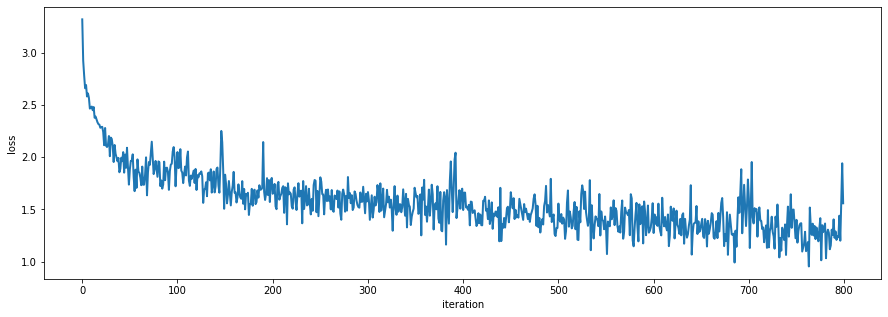

In [12]:
fig = plt.figure(figsize=(15,5))

plt.plot(logWF[0]['loss'],lw=2)
plt.xlabel('iteration')
plt.ylabel('loss');

Inspect the inferred posterior  
Find Maximum a posteriori estimation (MAP) - which is the mode of the posterior.  
Use kernel density estimate ratio to compare MAP to density at real parameters

Optimization terminated successfully.
         Current function value: -9.564628
         Iterations: 30
         Function evaluations: 58


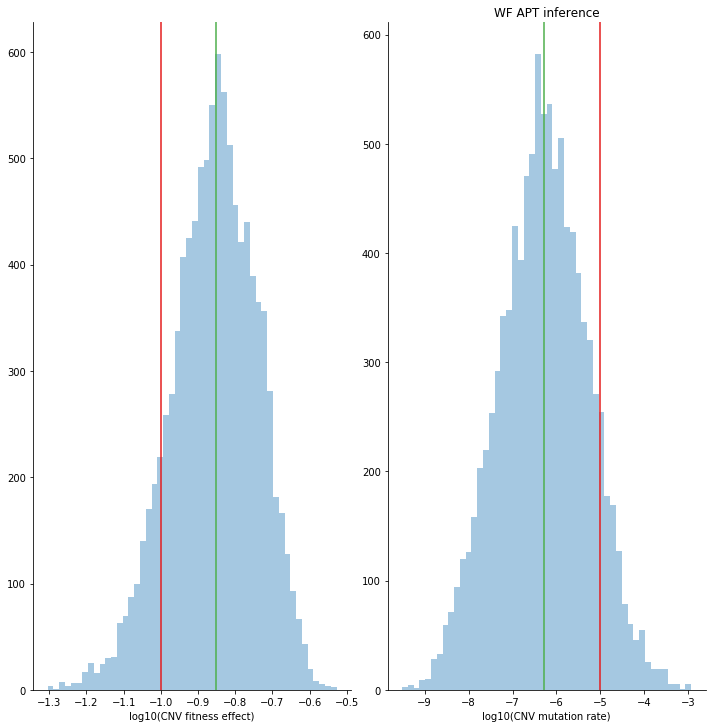

In [16]:
posterior_samples = [posteriorWF[0].gen(10000)]
fitness_samples = posterior_samples[0][:,0]
mut_samples = posterior_samples[0][:,1]
#calculations kde
ymin = fitness_samples.min()
ymax = fitness_samples.max()
xmin = mut_samples.min()
xmax = mut_samples.max()

s_range, μ_range = np.mgrid[ymin:ymax:100j, xmin:xmax:100j]
positions = np.vstack([s_range.ravel(), μ_range.ravel()])
values = np.vstack([fitness_samples, mut_samples])
kernel = scipy.stats.gaussian_kde(values)
density = np.reshape(kernel(positions).T, s_range.shape)

##
#estimates for parameters from the posterior (MAP - highest probability in posterior)
idx = np.argmax(density, axis=None)
param_guess = np.array([positions[0,idx],positions[1,idx]])
def kernelminus(x):
    return -kernel(x)
s_est, μ_est = scipy.optimize.minimize(kernelminus,param_guess, method ='Nelder-Mead', 
 options={'disp': True}).x

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# marginal
sns.distplot(fitness_samples, bins=50, kde=False, ax=axes[0])
sns.distplot(mut_samples, bins=50, kde=False, ax=axes[1]) 

axes[0].axvline(true_params[0], color=red, label="simulation parameter")
axes[0].axvline(s_est, color=green, label="MAP estimate")
axes[1].axvline(true_params[1], color=red, label="simulation parameter")
axes[1].axvline(μ_est, color=green, label="MAP estimate")


axes[0].set(xlabel='log10(CNV fitness effect)')
axes[1].set(xlabel='log10(CNV mutation rate)')


fig.tight_layout()
plt.title('WF APT inference')
sns.despine()


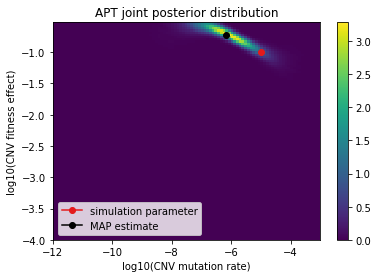

In [16]:
prior_min = np.log10(np.array([1e-4,1e-12]))
prior_max = np.log10(np.array([0.3,1e-3]))

s_range, μ_range = np.mgrid[np.log10(1e-4):np.log10(0.3):100j, np.log10(1e-12):np.log10(1e-3):100j]
positions = np.vstack([s_range.ravel(), μ_range.ravel()])
values = np.vstack([fitness_samples, mut_samples])
kernel = scipy.stats.gaussian_kde(values)
density = np.reshape(kernel(positions).T, s_range.shape)


#fig, axes = plt.subplots(1, 1, figsize=(10, 10))
plt.pcolormesh(μ_range, s_range, density)
plt.colorbar()
plt.plot(true_params[1],true_params[0], color=red, marker='o', label="simulation parameter")
plt.plot(μ_est, s_est, color="k", marker='o', label="MAP estimate")
plt.legend(loc='lower left')
#plt.label(xlabel='log10(CNV mutation rate)', ylabel='log10(CNV fitness effect)')
plt.xlabel('log10(CNV mutation rate)')
plt.ylabel('log10(CNV fitness effect)')
plt.title("Wright-Fisher APT joint posterior distribution")

Now, chemostat model  
Additional parameters describing the chemostat are needed for this model

In [19]:
A_inoc = 1e5
S_init = .800
D=0.12
μA=0.45
k=.103
y=3244500
I=.800
τ=1/10

## for local ##
seed_m = 3
m_Chemo = CNVevo(N, s_snv, m_snv, generation, EvoModel="Chemo", seed=seed_m)
g_Chemo = dg.Default(model=m_Chemo, prior=prior, summary=s)

Chemo observed data and summary stats

In [20]:
obs_Chemo = m_Chemo.gen_single(true_params)
obs_statsChemo = s.calc([obs_Chemo])

Hyperparameters for inference remain the same  
Inference:

In [24]:
seed_inf = 1

pilot_samples = 2000

# training schedule
n_train = 2000
n_rounds = 1

# fitting setup
minibatch = 256
epochs = 100
val_frac = 0.05

# network setup
n_hiddens = [50,50]

# convenience
prior_norm = True

# MAF parameters
density = 'maf'
n_mades = 5

In [26]:
# inference object
resChemo = infer.APT(g_Chemo,
                  obs=obs_statsChemo,
                  n_hiddens=n_hiddens,
                  seed=seed_inf,
                  pilot_samples=pilot_samples,
                  n_mades=n_mades,
                  prior_norm=prior_norm,
                  density=density)
# train
logChemo, _, posteriorChemo = resChemo.run(
                    n_train=n_train,
                    n_rounds=n_rounds,
                    minibatch=minibatch,
                    epochs=epochs,
                    silent_fail=False,
                    proposal='prior',
                    val_frac=val_frac,
                    verbose=True,)

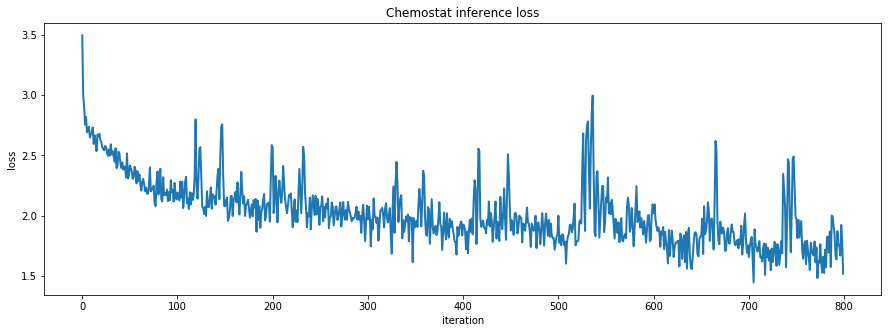

In [27]:
fig = plt.figure(figsize=(15,5))

plt.plot(logChemo[0]['loss'],lw=2)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title("Chemostat inference loss");

Inspect the inferred posterior  
Find Maximum a posteriori estimation (MAP) - which is the mode of the posterior.  
Use kernel density estimate ratio to compare MAP to density at real parameters

Optimization terminated successfully.
         Current function value: -0.110171
         Iterations: 25
         Function evaluations: 50


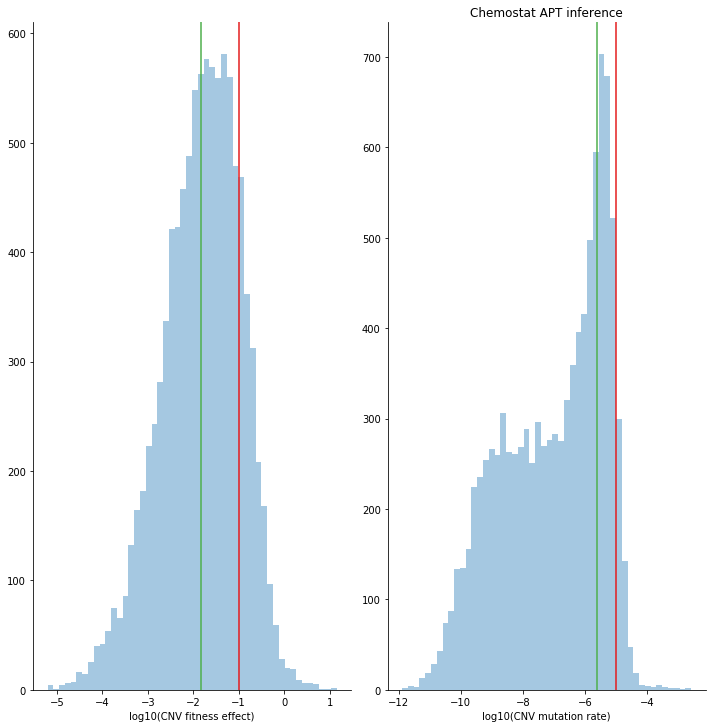

In [28]:
posterior_samples = [posteriorChemo[0].gen(10000)]
fitness_samples = posterior_samples[0][:,0]
mut_samples = posterior_samples[0][:,1]
#calculations kde
ymin = fitness_samples.min()
ymax = fitness_samples.max()
xmin = mut_samples.min()
xmax = mut_samples.max()

s_range, μ_range = np.mgrid[ymin:ymax:100j, xmin:xmax:100j]
positions = np.vstack([s_range.ravel(), μ_range.ravel()])
values = np.vstack([fitness_samples, mut_samples])
kernel = scipy.stats.gaussian_kde(values)
density = np.reshape(kernel(positions).T, s_range.shape)

##
#estimates for parameters from the posterior (MAP - highest probability in posterior)
idx = np.argmax(density, axis=None)
param_guess = np.array([positions[0,idx],positions[1,idx]])
def kernelminus(x):
    return -kernel(x)
s_est, μ_est = scipy.optimize.minimize(kernelminus,param_guess, method ='Nelder-Mead', 
 options={'disp': True}).x

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# marginal
sns.distplot(fitness_samples, bins=50, kde=False, ax=axes[0])
sns.distplot(mut_samples, bins=50, kde=False, ax=axes[1]) 

axes[0].axvline(true_params[0], color=red, label="simulation parameter")
axes[0].axvline(s_est, color=green, label="MAP estimate")
axes[0].legend()
axes[1].axvline(true_params[1], color=red, label="simulation parameter")
axes[1].axvline(μ_est, color=green, label="MAP estimate")
axes[1].legend()


axes[0].set(xlabel='log10(CNV fitness effect)')
axes[1].set(xlabel='log10(CNV mutation rate)')


fig.tight_layout()
plt.title('Chemostat APT inference')
sns.despine()

Text(0.5, 1.0, 'Chemostat APT joint posterior distribution')

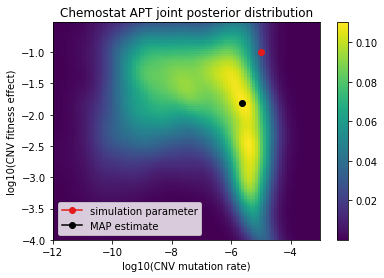

In [29]:
prior_min = np.log10(np.array([1e-4,1e-12]))
prior_max = np.log10(np.array([0.3,1e-3]))

s_range, μ_range = np.mgrid[np.log10(1e-4):np.log10(0.3):100j, np.log10(1e-12):np.log10(1e-3):100j]
positions = np.vstack([s_range.ravel(), μ_range.ravel()])
values = np.vstack([fitness_samples, mut_samples])
kernel = scipy.stats.gaussian_kde(values)
density = np.reshape(kernel(positions).T, s_range.shape)


#fig, axes = plt.subplots(1, 1, figsize=(10, 10))
plt.pcolormesh(μ_range, s_range, density)
plt.colorbar()
plt.plot(true_params[1],true_params[0], color=red, marker='o', label="simulation parameter")
plt.plot(μ_est, s_est, color="k", marker='o', label="MAP estimate")
plt.legend(loc='lower left')
#plt.label(xlabel='log10(CNV mutation rate)', ylabel='log10(CNV fitness effect)')
plt.xlabel('log10(CNV mutation rate)')
plt.ylabel('log10(CNV fitness effect)')
plt.title("Chemostat APT joint posterior distribution")